# Setup

In [1]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'http://konect.cc/files/download.tsv.epinions.tar.bz2'
dataset_id = '16'

# Download and extract data

In [2]:
filepath = f'{dataset_id}/edgelist.pkl'
if not os.path.isfile(filepath):
  edgelist = tlp.get_edgelist(url, dataset_id, verbose=True)
  edgelist = edgelist[
    edgelist['datetime'] > pd.Timestamp('2001-01-10 00:00:00')] # 70% of data is on 2001-01-09
  joblib.dump(edgelist, filepath)

download.tsv.epinions.tar.bz2:   0%|          | 0.00/3.21M [00:00<?, ?B/s]

This is likely a signed network (weight equals -1). 
Only positive weights will be used.
          


# Splitting

In [3]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist))
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 12.3 ms, sys: 12.2 ms, total: 24.5 ms
Wall time: 61 ms


# Instances

In [4]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 1min 6s, sys: 1.19 s, total: 1min 7s
Wall time: 1min 7s


# Targets

In [5]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/8471940 [00:00<?, ?it/s]

CPU times: user 11.3 s, sys: 273 ms, total: 11.6 s
Wall time: 11.6 s


# Sampling

In [6]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 178 ms, sys: 17.1 ms, total: 196 ms
Wall time: 217 ms


# Features

## AA (time agnostic)

In [7]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 3.18 s, sys: 22.8 ms, total: 3.2 s
Wall time: 3.22 s


## AA (time aware)

In [8]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 1min 43s, sys: 2.09 s, total: 1min 45s
Wall time: 1min 43s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

In [9]:
joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'].sort_values().drop_duplicates()

581858   2001-01-16 23:00:00
582178   2001-01-17 23:00:00
582596   2001-01-18 23:00:00
582818   2001-01-19 23:00:00
583161   2001-01-20 23:00:00
                 ...        
840329   2003-08-07 22:00:00
840489   2003-08-08 22:00:00
840791   2003-08-09 22:00:00
841139   2003-08-10 22:00:00
841335   2003-08-11 22:00:00
Name: datetime, Length: 938, dtype: datetime64[ns]

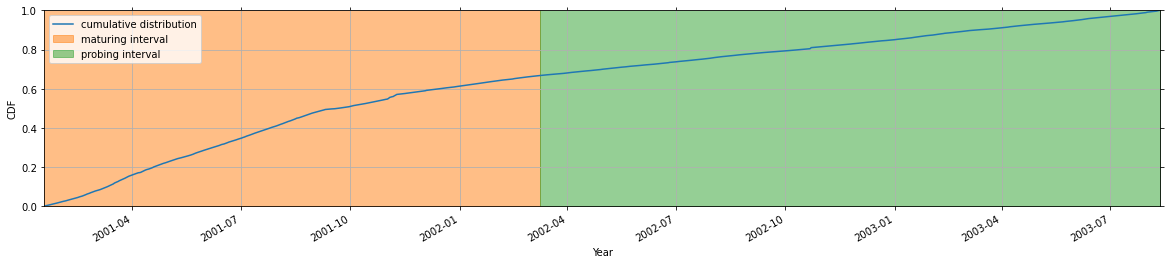

In [10]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'])

## Metric: Class imbalance

In [11]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,8463243,0.998973
True,8697,0.001027


## Figure: Datetime strategies

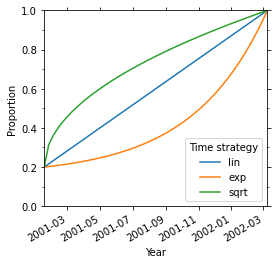

In [12]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

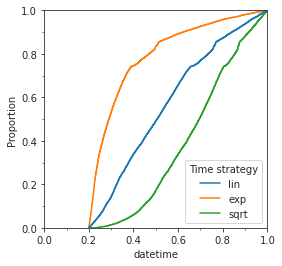

In [13]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

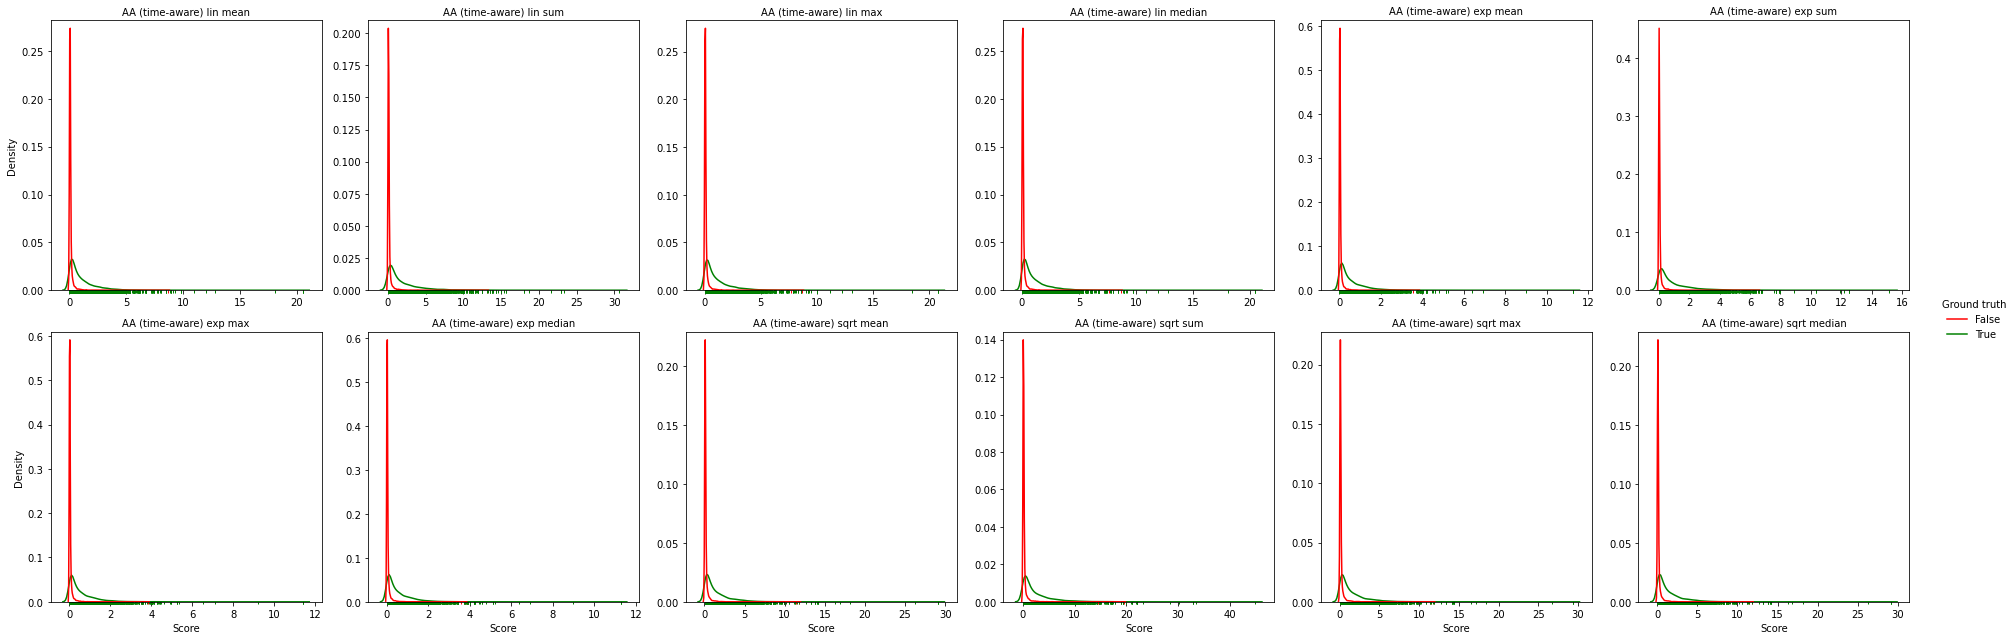

In [14]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

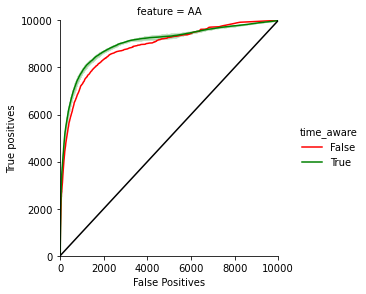

In [15]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [16]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.886965
         True        mean                  lin              0.899744
                     sum                   lin              0.905890
                     max                   lin              0.900389
                     median                lin              0.899744
                     mean                  exp              0.904704
                     sum                   exp              0.910189
                     max                   exp              0.905227
                     median                exp              0.904704
                     mean                  sqrt             0.899494
                     sum                   sqrt             0.904999
                     max                   sqrt             0.899950
                     median                sqrt             0.899494
Name: auc, dtype: float64